In [2]:
from huggingface_hub import hf_hub_download
import polars as pl

import pandas as pd

import matplotlib.pyplot as plt

import random

/Users/alpha_in_the_cap/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
hf_hub_download(
    repo_id='deepvk/VK-LSVD', 
    repo_type='dataset',
    filename='metadata/users_metadata.parquet', 
    local_dir='VK-LSVD'
)

users_metadata = pl.read_parquet('VK-LSVD/metadata/users_metadata.parquet')

avg_age = []

num_random_users = 100000
for i in range(100):
    random_users = users_metadata.sample(n=num_random_users, seed=int(random.random()*100))
    random_users = pd.DataFrame(random_users)
    random_users.columns = ['user_id', 'age', 'gender', 'geo', 'train_interactions_rank']
    age_i = random_users['age'].mean()
    avg_age.append(age_i)

print(sum(avg_age)/100)

36.721676399999986


## Tests

In [6]:
import scipy.stats as stats

In [53]:
U_p, T_p = [], []
for i in range(100):
    random_users = users_metadata.sample(n=num_random_users, seed=int(random.random()*100))
    random_users = pd.DataFrame(random_users)
    random_users.columns = ['user_id', 'age', 'gender', 'geo', 'train_interactions_rank']
    
    threshold = random_users['train_interactions_rank'].quantile(0.2)
    random_users['high_interest'] = (random_users['train_interactions_rank'] <= threshold).astype(int)

    age_high = random_users[random_users['high_interest'] == 1]['age']
    age_low = random_users[random_users['high_interest'] == 0]['age']

    stat, p = stats.shapiro(random_users['age'])

    if p > 0.05:
        t_stat, t_p_value = stats.ttest(age_high, age_low)
        T_p.append([t_p_value, age_high.mean(), age_low.mean()])
    else:
        u_stat, u_p_value = stats.mannwhitneyu(age_high, age_low)
        U_p.append([u_p_value, age_high.mean(), age_low.mean()])
        

/Users/alpha_in_the_cap/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)
/Users/alpha_in_the_cap/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)
/Users/alpha_in_the_cap/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)
/Users/alpha_in_the_cap/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_ou

In [58]:
print(sum([x[1] for x in U_p])/100)
print(sum([x[0] for x in U_p])/100)

36.525987
0.05714166807794866


In [8]:
age_high = random_users[random_users['high_interest'] == 1]['age']
age_low = random_users[random_users['high_interest'] == 0]['age']

(array([1809180., 1246654., 1347781., 1579020., 1251505., 1045837.,
         610424.,  443432.,  391026.,  275141.]),
 array([18. , 23.2, 28.4, 33.6, 38.8, 44. , 49.2, 54.4, 59.6, 64.8, 70. ]),
 <BarContainer object of 10 artists>)

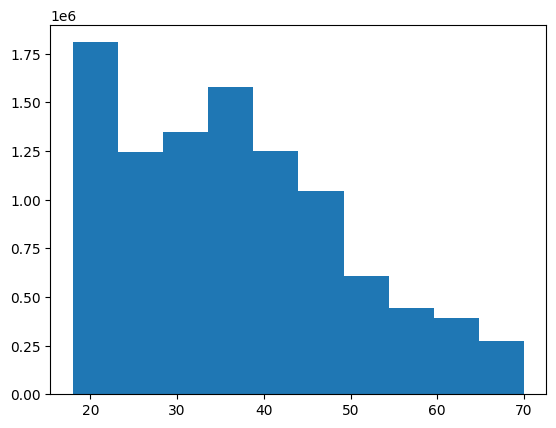

In [9]:
plt.hist(random_users['age'])

In [10]:
stat, p = stats.shapiro(random_users['age'])
print(f"Тест Шапиро-Уилка: статистика={stat:.4f}, p-значение={p:.4e}")
if p > 0.05:
    print("Данные выглядят нормально (не отвергаем нулевую гипотезу)")
else:
    print("Данные не выглядят нормально (отвергаем нулевую гипотезу)")

Тест Шапиро-Уилка: статистика=0.9577, p-значение=3.3865e-136
Данные не выглядят нормально (отвергаем нулевую гипотезу)


/Users/alpha_in_the_cap/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000000.
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
u_stat, u_p_value = stats.mannwhitneyu(age_high, age_low)
print(f"U-тест Манна-Уитни: U={u_stat:.0f}, p-value={u_p_value:.5f}")

U-тест Манна-Уитни: U=8087584142448, p-value=0.00000


In [18]:
print("\nОписательная статистика по возрасту:")
print("Высокий интерес:")
print(age_high.describe())
print("\nНизкий интерес:")
print(age_low.describe())


Описательная статистика по возрасту:
Высокий интерес:
count    2.000000e+06
mean     3.653128e+01
std      1.120060e+01
min      1.800000e+01
25%      2.800000e+01
50%      3.500000e+01
75%      4.300000e+01
max      7.000000e+01
Name: age, dtype: float64

Низкий интерес:
count    8.000000e+06
mean     3.677336e+01
std      1.314944e+01
min      1.800000e+01
25%      2.600000e+01
50%      3.500000e+01
75%      4.500000e+01
max      7.000000e+01
Name: age, dtype: float64


In [13]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

print("ПОДГОТОВКА ДАННЫХ ДЛЯ РЕГРЕССИОННОГО АНАЛИЗА")
print("=" * 50)

df = random_users.copy()

print("\n1. ЛИНЕЙНАЯ РЕГРЕССИЯ: Предсказание train_interactions_rank")

X_linear = df[['age', 'gender', 'geo']]
X_linear = pd.get_dummies(X_linear, columns=['gender', 'geo'], drop_first=True)
X_linear = sm.add_constant(X_linear)
y_linear = df['train_interactions_rank']

scaler = StandardScaler()
X_linear_scaled = X_linear.copy()
X_linear_scaled.iloc[:, 1:] = scaler.fit_transform(X_linear_scaled.iloc[:, 1:])

ПОДГОТОВКА ДАННЫХ ДЛЯ РЕГРЕССИОННОГО АНАЛИЗА

1. ЛИНЕЙНАЯ РЕГРЕССИЯ: Предсказание train_interactions_rank


/var/folders/84/q5hn4ghd627930_h_hxhl4lh0000gn/T/ipykernel_30615/648500343.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.44782718 -0.13493193 -0.13493193 ... -1.38651292 -1.46473674
 -0.6042748 ]' has dtype incompatible with uint32, please explicitly cast to a compatible dtype first.
  X_linear_scaled.iloc[:, 1:] = scaler.fit_transform(X_linear_scaled.iloc[:, 1:])
/var/folders/84/q5hn4ghd627930_h_hxhl4lh0000gn/T/ipykernel_30615/648500343.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.8912743   0.8912743  -1.12198904 ... -1.12198904  0.8912743
  0.8912743 ]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X_linear_scaled.iloc[:, 1:] = scaler.fit_transform(X_linear_scaled.iloc[:, 1:])
/var/folders/84/q5hn4ghd627930_h_hxhl4lh0000gn/T/ipykernel_30615/648500343.py:20: FutureWarning: Settin

In [14]:
model_linear = sm.OLS(y_linear, X_linear_scaled).fit()
print(model_linear.summary())

                               OLS Regression Results                              
Dep. Variable:     train_interactions_rank   R-squared:                       0.040
Model:                                 OLS   Adj. R-squared:                  0.040
Method:                      Least Squares   F-statistic:                     5099.
Date:                     Mon, 10 Nov 2025   Prob (F-statistic):               0.00
Time:                             19:22:33   Log-Likelihood:            -1.6274e+08
No. Observations:                 10000000   AIC:                         3.255e+08
Df Residuals:                      9999918   BIC:                         3.255e+08
Df Model:                               81                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [15]:
print("\nЗНАЧИМЫЕ ФАКТОРЫ (p < 0.05):")
significant_factors = model_linear.pvalues[model_linear.pvalues < 0.05]
for factor, p_val in significant_factors.items():
    coef = model_linear.params[factor]
    print(f"{factor}: коэффициент = {coef:.4f}, p-value = {p_val:.5f}")


ЗНАЧИМЫЕ ФАКТОРЫ (p < 0.05):
const: коэффициент = 4999999.5000, p-value = 0.00000
age: коэффициент = -78597.3818, p-value = 0.00000
gender_2: коэффициент = 59206.3631, p-value = 0.00000
geo_1: коэффициент = -40478.3786, p-value = 0.00000
geo_2: коэффициент = -40714.7362, p-value = 0.00000
geo_3: коэффициент = -11994.5278, p-value = 0.00000
geo_4: коэффициент = -74176.8917, p-value = 0.00000
geo_5: коэффициент = -5229.7835, p-value = 0.00037
geo_6: коэффициент = 21193.0440, p-value = 0.00000
geo_7: коэффициент = 15796.7582, p-value = 0.00000
geo_8: коэффициент = -102963.6258, p-value = 0.00000
geo_9: коэффициент = -4956.0715, p-value = 0.00166
geo_10: коэффициент = -102936.0552, p-value = 0.00000
geo_11: коэффициент = -40531.3028, p-value = 0.00000
geo_12: коэффициент = -106608.8677, p-value = 0.00000
geo_13: коэффициент = -105238.1597, p-value = 0.00000
geo_14: коэффициент = -74850.4720, p-value = 0.00000
geo_15: коэффициент = -122359.5581, p-value = 0.00000
geo_16: коэффициент = -798